## 0. Importing Libraries

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

import pandas as pd
assert pd.__version__ >= "1.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

## 1. Loading Data

In [61]:
features, target = load_svmlight_file('diabetes.txt')

features = features.toarray()
target = target.reshape(target.shape[0],1)

print(f"Size of features: {features.shape}")
print(f"Size of target: {target.shape}")

Size of features: (768, 8)
Size of target: (768, 1)


In [62]:
pd.DataFrame(features).describe()

,0,1,2,3,4,5,6,7
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.547641,0.215020,0.132877,-0.585122,-0.811349,-0.046421,-0.663641,-0.591971
std,0.396421,0.321333,0.317308,0.322267,0.272444,0.234997,0.282945,0.392008
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858455,-0.900000
50%,-0.647059,0.175879,0.180328,-0.535354,-0.927896,-0.046200,-0.748506,-0.733333
75%,-0.294118,0.409547,0.311475,-0.353535,-0.699173,0.090909,-0.531811,-0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.Exploratory data analysis

In [63]:
# split the dataset
X_bigtrain, X_test, y_bigtrain, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_bigtrain, y_bigtrain , test_size=0.2, random_state=42, stratify=y_bigtrain)

print(f'Shapes of sets are {[X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape]}')

Shapes of sets are [(491, 8), (491, 1), (154, 8), (154, 1), (123, 8), (123, 1)]


In [64]:
## EDA 
colnames=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','label']

df = pd.DataFrame(features)
df['Outcome']=target

df.columns=colnames

df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,label
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0


In [65]:
# Code fragment to help with plotting histograms combining matplotlib and seaborn (and pandas)
def hist_plot(features, Nrows, Ncols):

    fig, axes = plt.subplots(Nrows, Ncols, figsize=(20, 20))

    for row in range(Nrows):
        for col in range(Ncols):
            feature = features[row * Ncols + col]
            sns.histplot(data=df, x=feature, hue="label", bins='auto', kde=True, ax=axes[row,col], edgecolor=None)
            # sns.boxplot(y=feature,x='label',data=df, ax=axes[row,col])

    plt.show()   

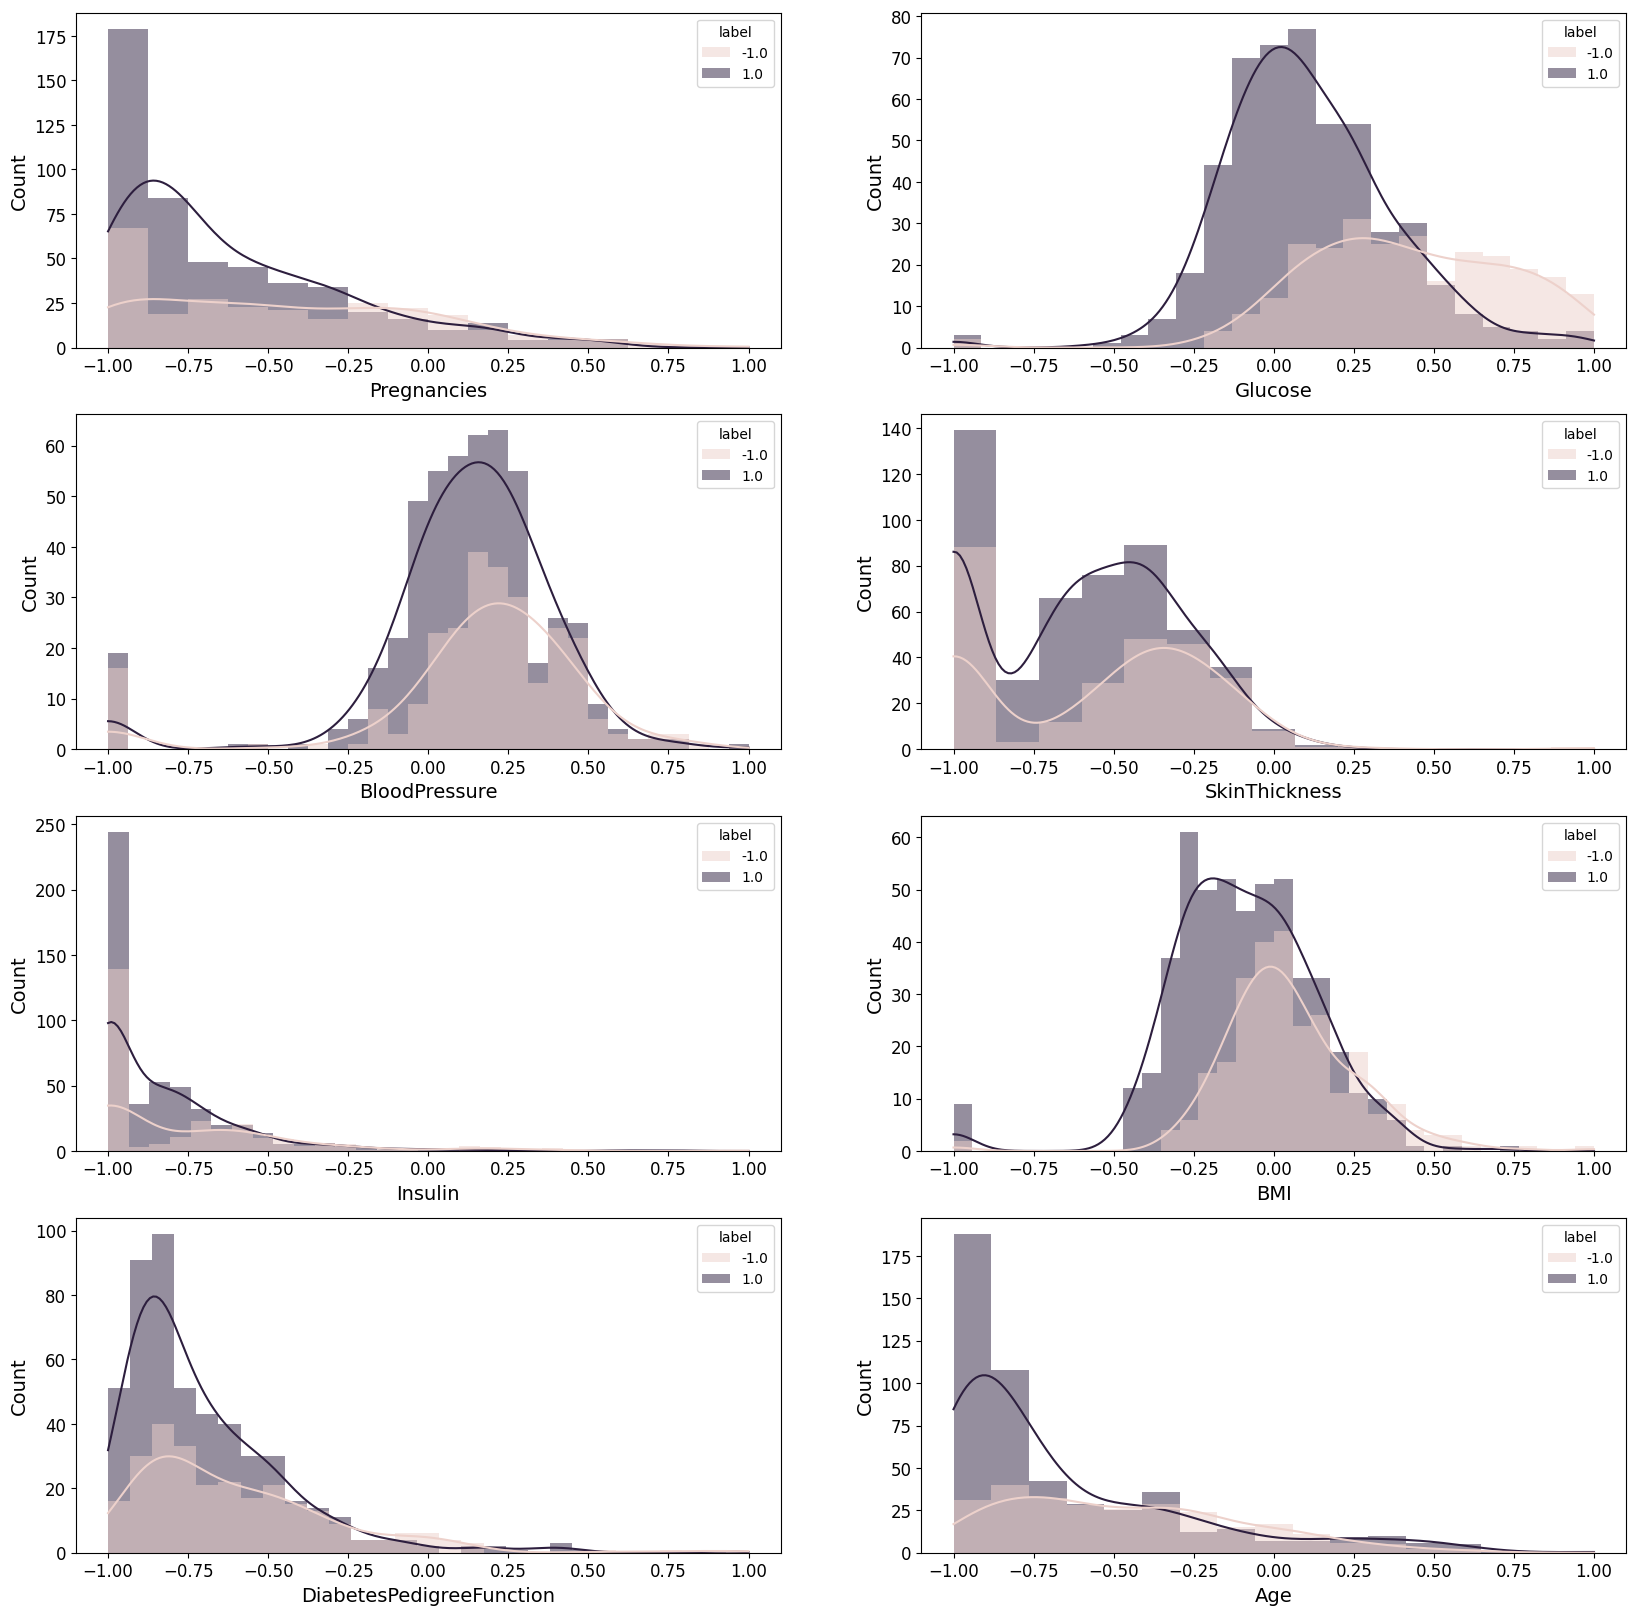

In [66]:
hist_plot(colnames,4,2)

## 3.Model Implement

In [67]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

comparison_model = Perceptron(eta0=0.01, max_iter=20)


# Train model (20 epochs)
fitted_model = comparison_model.fit(X_train,
                                    y_train.reshape((y_train.shape[0],)))
predictions = fitted_model.predict(X_val)

print("Validation accuracy = ", accuracy_score(y_val, predictions))

Validation accuracy =  0.7642276422764228


## Perceptron Implementation

In [171]:
class Perceptron:
    def __init__(self, X_train, y_train, X_val, y_val, lr = 1,loss_type="zero-one", seed = -1, randomBias = False, 
                 bias = False, weight_val = 0, earlyStopping = -1):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.lr = lr
        self.loss_type = loss_type
        self.seed = seed
        self.randomBias = randomBias
        self.bias = bias
        self.weight_val = weight_val
        self.earlyStopping= earlyStopping
        self.originalEarlyStopping = self.earlyStopping
        self.weightVectors = []

        self.weights = self.initializeWeights()
       
        self.trainingAccuracies = []
        self.validationAccuracies = []
        self.weightVectors = []
        self.trainingLosses = []
        self.validationLosses = []
        self.testLosses = []
        
        self.currentBestValAccuracy = 0
        self.currentBestIndex = 0
        
        self.predictions = np.array([])
               
    def _biasColumn(self, array):    
        return np.append(np.ones(array.shape[0]).reshape(array.shape[0],1), array, axis= 1)
        
        
    def initializeWeights(self):
        if self.seed >= 0:
            np.random.seed(self.seed)
        
        if self.weight_val == 1:
            if self.bias:
                weights = np.ones(self.X_train.shape[1]+1)
            else:
                weights = np.ones(self.X_train.shape[1])
        elif self.weight_val == 0:
            if self.bias:
                weights = np.zeros(self.X_train.shape[1]+1)
            else:
                weights = np.zeros(self.X_train.shape[1])
        else:
            if self.bias:
                weights = np.random.rand(self.X_train.shape[1]+1)
            else:
                weights = np.random.rand(self.X_train.shape[1])
            
        return weights
    
    
    def train(self, epochs = 10, verbose = True, showPlots = True):

        self.currentBestValAccuracy = 0
        for i in range(epochs):
            
            # update weights
            if self.bias:
                self.X_train = self._biasColumn(self.X_train)
                self.y_train = self._biasColumn(self.X_val)

            sum = 0
    
            for X, y in zip(self.X_train, self.y_train):
                sum = sum + (y * X * (self._base_step_func(X, y, self.weights)))

            self.weights += self.lr * sum

            self.weightVectors.append(self.weights)
    
            # Store loss value
            self._storeValLossAndAccuracy()
            self._storeTrainLossAndAccuracy()
            
            # Display epoch by epoch results
            if verbose:
                print("Epoch {}:".format(i + 1))
                print("Training Acc:", self.trainingAccuracies[i])
                print("Validation Acc:", self.validationAccuracies[i])
                print("Training Loss:", self.trainingLosses[i])
                print("Validation Loss:", self.validationLosses[i], "\n")
                
            if self.earlyStopping == 0:
                print("Early stopped at epoch", (i + 1))
                break

               
        if showPlots:
            # Plot graphs of loss and accuracy
            plt.title("Loss curves")
            plt.plot(np.arange(0, len(self.trainingLosses)), self.trainingLosses, label="Training loss")
            plt.plot(np.arange(0, len(self.validationLosses)),
                    self.validationLosses, label="Validation loss")
            plt.xlabel("Number of epochs")
            plt.ylabel("Loss")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()
            
            plt.title("Accuracy curves")
            plt.plot(np.arange(0, len(self.trainingAccuracies)),
                    self.trainingAccuracies, label="Training Accuracy")
            plt.plot(np.arange(0, len(self.validationAccuracies)),
                    self.validationAccuracies, label="Validation Accuracy")
            plt.xlabel("Number of epochs")
            plt.ylabel("Accuracy")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()
                
    def _base_step_func(self, feature, label, weights): # Threshold function
        step = (1 if np.dot(feature, weights) * label <= 0 else 0)
        return step

    def _storeValLossAndAccuracy(self):

        loss = self._loss_func(self.loss_type, self.X_val, self.y_val, self.weights)
        pred, accuracy = self._pred_accuracy(self.X_val, self.y_val, self.weights)
        
        self.validationLosses.append(loss)
        self.validationAccuracies.append(accuracy)
        
        # Store best accuracy
        if accuracy >= self.currentBestValAccuracy:
            self.currentBestValAccuracy = accuracy
            self.currentBestIndex = len(self.validationAccuracies) - 1
            self.earlyStopping = self.originalEarlyStopping
        else:
            self.earlyStopping -= 1
        
    def _storeTrainLossAndAccuracy(self):
        
        loss = self._loss_func(self.loss_type, self.X_train, self.y_train, self.weights)
        pred, accuracy = self._pred_accuracy(self.X_train, self.y_train, self.weights)
        
        self.trainingLosses.append(loss)
        self.trainingAccuracies.append(accuracy)
            
    def predict(self, X):
        predictions = np.sign(np.matmul(X, self.weights))
        return predictions
    
    def calc_accuracy(self, actual, predictions):
        count = 0
        length = len(actual)
        for i in range(length):
            if actual[i] == predictions[i]:
                count += 1
        return count / length
    
    # Claculate accuracy
    def _pred_accuracy(self, features, target, weights): # Function to find accuracy score for predictions
        
        preds = np.sign(np.dot(features, weights))
        cnt = 0
        for pred, t in zip(preds, target):
            if pred == t:
                cnt += 1  
        accuracy = cnt/features.shape[0]
        return preds, accuracy
    
    # Claculate loss for different loss types
    def _loss_func(self, loss_type, features, target, weights): 

        sum_loss = 0
        for X, y in zip(features, target):

            if loss_type == "zero-one": # Loss for Zero-one loss base_step_func(row, label, weights)
                # sum_loss += (1 if np.dot(X, weights) * y <= 0 else 0)
                sum_loss += self._base_step_func(X, y, weights)
            elif loss_type == "perceptron": # Loss for Perceptron Loss
                sum_loss += max(0, - y * (np.dot(X, weights)))
            elif loss_type == "hinge": # Loss for Hinge Loss
                sum_loss += max(0, 1 - y * (np.dot(X, weights)))    
            else:
                raise Exception("Wrong Loss Function!")   


        return sum_loss/features.shape[0]
    
    def evaluate(self, X, y):
        predictions = np.array([])
        if self.bias:
            X_new = self._addBiasColumnToTest(X)
            predictions = self.predict(X_new)
        else:
            predictions = self.predict(X)
        self.predictions = predictions
        return self.calc_accuracy(y, predictions)
    
    def getBestParameters(self):
        return (self.weightVectors[self.currentBestIndex],
                self.trainingAccuracies[self.currentBestIndex],
                self.validationAccuracies[self.currentBestIndex])
    
    def setBestWeights(self):
        self.weights = self.weightVectors[self.currentBestIndex]

    def showBestAccuracy(self):
        best_accuracy = self.validationAccuracies[self.currentBestIndex]
        print(f"----- Best Accuracy is {best_accuracy*100:.2f} % ------")    
        

Epoch 1:
Training Acc: 0.6496945010183299
Validation Acc: 0.6504065040650406
Training Loss: 0.35030549898167007
Validation Loss: 0.34959349593495936 

Epoch 2:
Training Acc: 0.7474541751527495
Validation Acc: 0.7560975609756098
Training Loss: 0.2525458248472505
Validation Loss: 0.24390243902439024 

Epoch 3:
Training Acc: 0.35234215885947046
Validation Acc: 0.34146341463414637
Training Loss: 0.6476578411405295
Validation Loss: 0.6585365853658537 

Epoch 4:
Training Acc: 0.6517311608961304
Validation Acc: 0.6504065040650406
Training Loss: 0.34826883910386963
Validation Loss: 0.34959349593495936 

Epoch 5:
Training Acc: 0.6639511201629328
Validation Acc: 0.6991869918699187
Training Loss: 0.3360488798370672
Validation Loss: 0.3008130081300813 

Epoch 6:
Training Acc: 0.5865580448065173
Validation Acc: 0.5853658536585366
Training Loss: 0.4134419551934827
Validation Loss: 0.4146341463414634 

Epoch 7:
Training Acc: 0.6619144602851323
Validation Acc: 0.6991869918699187
Training Loss: 0.33808

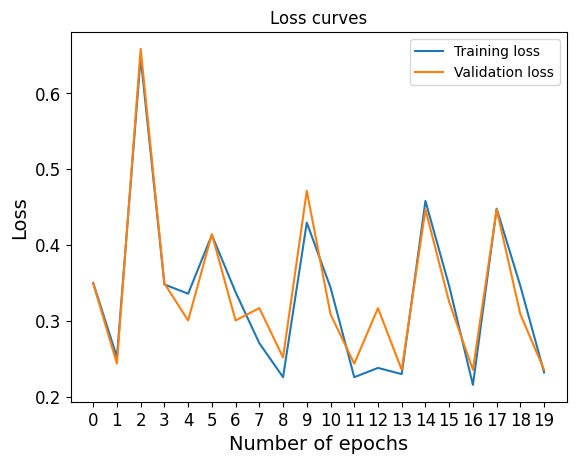

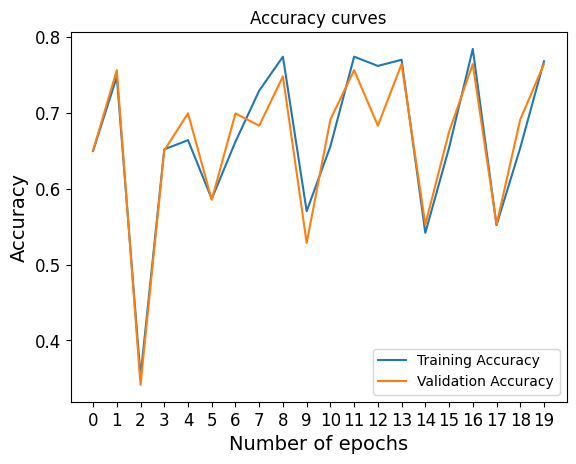

----- Best Accuracy is 76.42 % ------


In [172]:
# Create a simple perceptron (with 0-1 loss)
perceptron = Perceptron(X_train, y_train, X_val, y_val, lr=0.01, loss_type="zero-one", bias=False,
                        seed=200, randomBias=False, earlyStopping=20)
perceptron.train(epochs=20, verbose=True)

# Choose the best model 
perceptron.setBestWeights()

# show best accuracy
perceptron.showBestAccuracy()

In [186]:
class Adaline(Perceptron):
    def train(self, epochs = 10, verbose = True, showPlots = True):

        self.currentBestValAccuracy = 0
        for i in range(epochs):
            
            # update weights
            if self.bias:
                self.X_train = self._biasColumn(self.X_train)
                self.y_train = self._biasColumn(self.X_val)
    
            sum = 0
            for X, y in zip(self.X_train, self.y_train):
                prod = np.dot(X, self.weights)
                # sum = sum + (y - prod) * X
                # sum = sum + (y * X * (self._base_step_func(X, y, self.weights)))
                self.weights += (self.lr * 4 * (y - prod) * X)
                self.weightVectors.append(self.weights)
    
                # Store loss value
                self._storeValLossAndAccuracy()
                self._storeTrainLossAndAccuracy()
            
                # Display epoch by epoch results
                if verbose:
                    print("Epoch {}:".format(i + 1))
                    print("Training Acc:", self.trainingAccuracies[i])
                    print("Validation Acc:", self.validationAccuracies[i])
                    print("Training Loss:", self.trainingLosses[i])
                    print("Validation Loss:", self.validationLosses[i], "\n")
                
                if self.earlyStopping == 0:
                    print("Early stopped at epoch", (i + 1))
                    break

        if showPlots:
            # Plot graphs of loss and accuracy
            plt.title("Loss curves")
            plt.plot(np.arange(0, len(self.trainingLosses)), self.trainingLosses, label="Training loss")
            plt.plot(np.arange(0, len(self.validationLosses)),self.validationLosses, label="Validation loss")
            plt.xlabel("Number of epochs")
            plt.ylabel("Loss")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()
            
            plt.title("Accuracy curves")
            plt.plot(np.arange(0, len(self.trainingAccuracies)),
                    self.trainingAccuracies, label="Training Accuracy")
            plt.plot(np.arange(0, len(self.validationAccuracies)),
                    self.validationAccuracies, label="Validation Accuracy")
            plt.xlabel("Number of epochs")
            plt.ylabel("Accuracy")
            plt.xticks(np.arange(0, epochs))
            plt.legend()
            plt.show()    

Epoch 1:
Training Acc: 0.6537678207739308
Validation Acc: 0.6666666666666666
Training Loss: 0.34623217922606925
Validation Loss: 0.3333333333333333 

Epoch 1:
Training Acc: 0.6537678207739308
Validation Acc: 0.6666666666666666
Training Loss: 0.34623217922606925
Validation Loss: 0.3333333333333333 

Epoch 1:
Training Acc: 0.6537678207739308
Validation Acc: 0.6666666666666666
Training Loss: 0.34623217922606925
Validation Loss: 0.3333333333333333 

Epoch 1:
Training Acc: 0.6537678207739308
Validation Acc: 0.6666666666666666
Training Loss: 0.34623217922606925
Validation Loss: 0.3333333333333333 

Epoch 1:
Training Acc: 0.6537678207739308
Validation Acc: 0.6666666666666666
Training Loss: 0.34623217922606925
Validation Loss: 0.3333333333333333 

Epoch 1:
Training Acc: 0.6537678207739308
Validation Acc: 0.6666666666666666
Training Loss: 0.34623217922606925
Validation Loss: 0.3333333333333333 

Epoch 1:
Training Acc: 0.6537678207739308
Validation Acc: 0.6666666666666666
Training Loss: 0.346232

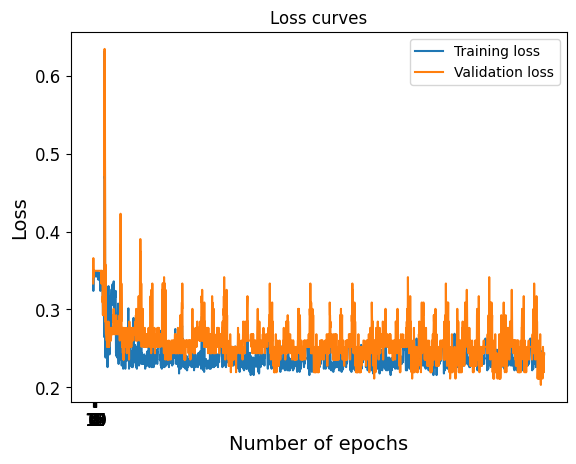

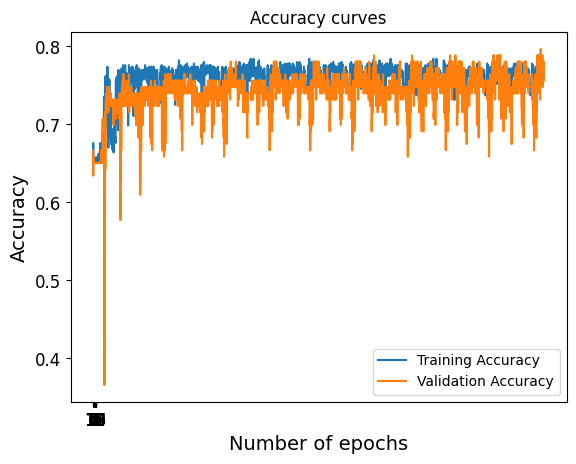

----- Best Accuracy is 79.67 % ------


In [187]:
# Create a simple perceptron
adaline = Adaline(X_train, y_train, X_val, y_val, lr=0.01, loss_type="zero-one", bias=False,
                        seed=200, randomBias=False, earlyStopping=20)
adaline.train(epochs=20, verbose=True)

# Set best weights
adaline.showBestAccuracy()